In [1]:
import warnings, os, pickle, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prog.tools import *
from prog.db import Database
warnings.filterwarnings('ignore')

shuffle = False
random_state = 99

In [2]:
input_ = {
    "model_id": "20230710105600",
    "start_time": "2021-01-01",
    "end_time": "2024-12-30"
}

In [3]:
model_id = input_["model_id"]
start_time = input_["start_time"]
end_time = input_["end_time"]

root = os.getcwd()

# 取得train位置
train_path = os.path.join(root, "data", "train")        
os.makedirs(train_path, exist_ok = True)
output_json = os.path.join(train_path, "output.json")


# 取得model位置
model_path = os.path.join(root, "data", "train", model_id)
os.makedirs(model_path, exist_ok = True)

model_detail = os.path.join(model_path, "model")
os.makedirs(model_detail, exist_ok = True)


# 取得config        
config_path = os.path.join(root, "prog", "config.json")
with open(config_path, 'r') as f:
    config = json.load(f)

### Get data from database

In [4]:
db_con = config["database"]
db = Database(db_con)

# df = pd.read_csv(r"C:\Users\tzuli\Documents\python\ChuanMai\data\sort\data.csv")
df = db.get_data(db_con["table"]["train"], input_["start_time"], input_["end_time"])
df = df.sort_values("serial").reset_index(drop = True)

df = df[~(df[["length", "width"]] <= 0).any(axis = 1)].reset_index() # 長寬為0無法切割
df = df[["order_id", "cabinet", "item_name", "color", "length", "width", "e_ship_date"]]
print(f"shape = {df.shape}")
df.head(3)

shape = (18526, 7)


,order_id,cabinet,item_name,color,length,width,e_ship_date
0,BC11205013,01_矮櫃,背拉,*不拘_18,443.0,96.0,2024-05-03
1,BS11202160,01_矮櫃,背拉,*不拘_18,964.0,96.0,2024-03-01
2,BS11202160,01_矮櫃,背拉,*不拘_18,964.0,96.0,2024-03-01


### Calculate area

In [5]:
df["area"] = df["length"] * df["width"] # 每個矩形的面積
length_limit = config["limit"]["length"]
width_limit = config["limit"]["width"]
area_limit = length_limit * width_limit
df["area_prob"] = df["area"] / area_limit # 矩形站箱子的面積
df.head(3)

,order_id,cabinet,item_name,color,length,width,e_ship_date,area,area_prob
0,BC11205013,01_矮櫃,背拉,*不拘_18,443.0,96.0,2024-05-03,42528.0,0.004725
1,BS11202160,01_矮櫃,背拉,*不拘_18,964.0,96.0,2024-03-01,92544.0,0.010283
2,BS11202160,01_矮櫃,背拉,*不拘_18,964.0,96.0,2024-03-01,92544.0,0.010283


### Calculate waste and plate_id

In [6]:
df = calculate_waste(df, length_limit, width_limit)
df.head(3)

,order_id,cabinet,item_name,color,length,width,e_ship_date,area,area_prob,waste,plate_id
0,BC11205013,01_矮櫃,背拉,*不拘_18,443.0,96.0,2024-05-03,42528.0,0.004725,0.995275,1
1,BS11202160,01_矮櫃,背拉,*不拘_18,964.0,96.0,2024-03-01,92544.0,0.010283,0.984992,1
2,BS11202160,01_矮櫃,背拉,*不拘_18,964.0,96.0,2024-03-01,92544.0,0.010283,0.974709,1


### 基礎耗損率

In [7]:
waste_score = calculate_mean_wast(df, waste_json = None)
waste_score["plate"]

{'waste': 0.0809, 'plate': 632, 'no_rm_waste': 0.2157, 'no_rm_plate': 824}

### 計算第n個類型的產品佔該類型產品總數量的比值

In [8]:
df = calculate_num(col = ["color"], df = df, target = "color", flag = "train")
df = calculate_num(col = ["cabinet"], df = df, target = "cabinet", flag = "train")
df = calculate_num(col = ["color", "cabinet"], df = df, target = "color_cabinet", flag = "train")
df = calculate_num(col = ["color", "length", "width"], df = df, target = "color_item", flag = "train")
df = calculate_num(col = ["color", "cabinet", "length", "width"], df = df, target = "item", flag = "train")
df.head(3)

,order_id,cabinet,item_name,color,length,width,e_ship_date,area,area_prob,waste,plate_id,color_num,cabinet_num,color_cabinet_num,color_item_num,item_num
0,BC11205013,01_矮櫃,背拉,*不拘_18,443.0,96.0,2024-05-03,42528.0,0.004725,0.995275,1,0.000768,0.002519,0.047619,1.000000,1.0
1,BS11202160,01_矮櫃,背拉,*不拘_18,964.0,96.0,2024-03-01,92544.0,0.010283,0.984992,1,0.001536,0.005038,0.095238,0.052632,0.5
2,BS11202160,01_矮櫃,背拉,*不拘_18,964.0,96.0,2024-03-01,92544.0,0.010283,0.974709,1,0.002304,0.007557,0.142857,0.105263,1.0


In [9]:
df = calculate_num(col = ["order_id", "color"], df = df, target = "color1", flag = "train")
df = calculate_num(col = ["order_id", "cabinet"], df = df, target = "cabinet1", flag = "train")
df = calculate_num(col = ["order_id", "color", "cabinet"], df = df, target = "color_cabinet1", flag = "train")
df = calculate_num(col = ["order_id", "color", "length", "width"], df = df, target = "color_item1", flag = "train")
df = calculate_num(col = ["order_id", "color", "cabinet", "length", "width"], df = df, target = "item1", flag = "train")
df.head(3)

,order_id,cabinet,item_name,color,length,width,e_ship_date,area,area_prob,waste,...,color_num,cabinet_num,color_cabinet_num,color_item_num,item_num,color1_num,cabinet1_num,color_cabinet1_num,color_item1_num,item1_num
0,BC11205013,01_矮櫃,背拉,*不拘_18,443.0,96.0,2024-05-03,42528.0,0.004725,0.995275,...,0.000768,0.002519,0.047619,1.000000,1.0,1.000000,0.142857,1.0,1.00,1.0
1,BS11202160,01_矮櫃,背拉,*不拘_18,964.0,96.0,2024-03-01,92544.0,0.010283,0.984992,...,0.001536,0.005038,0.095238,0.052632,0.5,0.027027,0.038462,0.5,0.25,0.5
2,BS11202160,01_矮櫃,背拉,*不拘_18,964.0,96.0,2024-03-01,92544.0,0.010283,0.974709,...,0.002304,0.007557,0.142857,0.105263,1.0,0.054054,0.076923,1.0,0.50,1.0


### Generate label

In [10]:
target = "label"
df = generate_label(df, target)
df.head(3)

,label,order_id,cabinet,item_name,color,length,width,e_ship_date,area,area_prob,...,color_num,cabinet_num,color_cabinet_num,color_item_num,item_num,color1_num,cabinet1_num,color_cabinet1_num,color_item1_num,item1_num
0,1,BC11205013,01_矮櫃,背拉,*不拘_18,443.0,96.0,2024-05-03,42528.0,0.004725,...,0.000768,0.002519,0.047619,1.000000,1.0,1.000000,0.142857,1.0,1.00,1.0
1,0,BS11202160,01_矮櫃,背拉,*不拘_18,964.0,96.0,2024-03-01,92544.0,0.010283,...,0.001536,0.005038,0.095238,0.052632,0.5,0.027027,0.038462,0.5,0.25,0.5
2,2,BS11202160,01_矮櫃,背拉,*不拘_18,964.0,96.0,2024-03-01,92544.0,0.010283,...,0.002304,0.007557,0.142857,0.105263,1.0,0.054054,0.076923,1.0,0.50,1.0


In [11]:
df.to_csv("data/raw/eda.csv", index = False)

In [12]:
df = df.drop(["order_id", "cabinet", "item_name", "color", "e_ship_date"], axis = 1)
df.head(3)

,label,length,width,area,area_prob,waste,color_num,cabinet_num,color_cabinet_num,color_item_num,item_num,color1_num,cabinet1_num,color_cabinet1_num,color_item1_num,item1_num
0,1,443.0,96.0,42528.0,0.004725,0.995275,0.000768,0.002519,0.047619,1.000000,1.0,1.000000,0.142857,1.0,1.00,1.0
1,0,964.0,96.0,92544.0,0.010283,0.984992,0.001536,0.005038,0.095238,0.052632,0.5,0.027027,0.038462,0.5,0.25,0.5
2,2,964.0,96.0,92544.0,0.010283,0.974709,0.002304,0.007557,0.142857,0.105263,1.0,0.054054,0.076923,1.0,0.50,1.0


### Split data

In [13]:
features = list(df.columns[1:])
target = "label"

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop(target, axis = 1), df[target], test_size = 0.2, shuffle = shuffle)#, stratify = df["label"])
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(14820, 15) (3706, 15) (14820,) (3706,)


#### 調整資料集

In [15]:
train_drop_index = pickle.load(open(os.path.join(model_detail, "train_drop_index.pkl"), "rb"))
test_drop_index = pickle.load(open(os.path.join(model_detail, "test_drop_index.pkl"), "rb"))

X_train = X_train.drop(train_drop_index, axis = 0).reset_index(drop = True)
y_train = y_train.drop(train_drop_index, axis = 0).reset_index(drop = True)
X_test = X_test.drop(test_drop_index, axis = 0).reset_index(drop = True)
y_test = y_test.drop(test_drop_index, axis = 0).reset_index(drop = True)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(14000, 15) (2419, 15) (14000,) (2419,)


### outlier

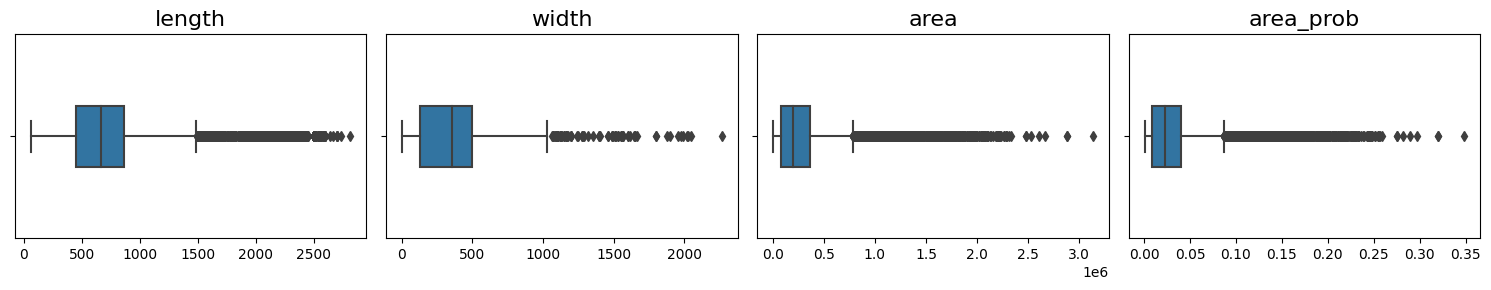

In [16]:
a, b = 1, 4
k = 0
fig, ax = plt.subplots(a, b, figsize = (15, 3))
for i in range(a):
    for j in range(b):
        sns.boxplot(x = features[k], data = X_train, width = 0.3, ax = ax[j])
        ax[j].set(xlabel = None, ylabel = None)
        ax[j].set_title(features[k], fontsize = 16)
        k += 1

plt.tight_layout()

In [17]:
outlier_boundary = {}
for col in features:
    Q1   = X_train[col].quantile(0.25)
    Q3   = X_train[col].quantile(0.75)
    IQR  = Q3 - Q1
    min_ = Q1 - (1.5 * IQR)
    max_ = Q3 + (1.5 * IQR)
    
    X_train[col] = X_train[col].apply(lambda X: max_ if X > max_ else X)
    X_train[col] = X_train[col].apply(lambda X: min_ if X < min_ else X)

    X_test[col] = X_test[col].apply(lambda X: max_ if X > max_ else X)
    X_test[col] = X_test[col].apply(lambda X: min_ if X < min_ else X)

    outlier_boundary[col] = {
        "min": min_,
        "max": max_,
    }

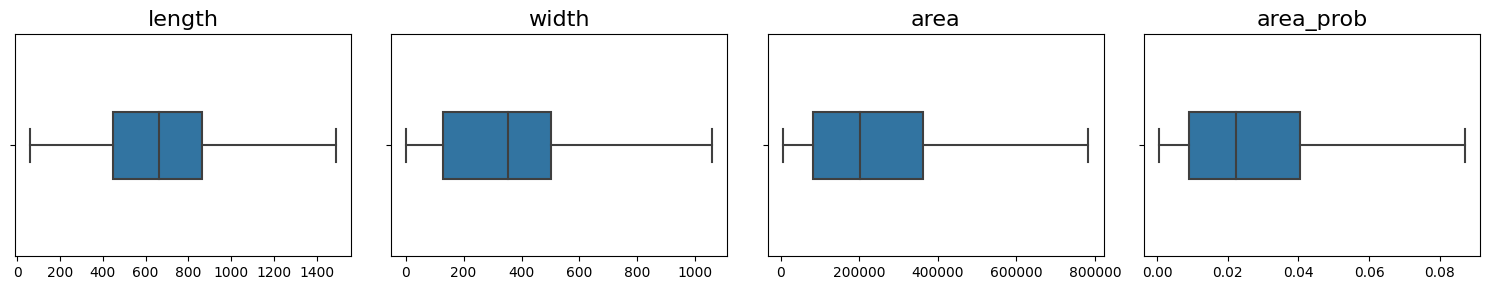

In [18]:
a, b = 1, 4
k = 0
fig, ax = plt.subplots(a, b, figsize = (15, 3))
for i in range(a):
    for j in range(b):
        sns.boxplot(x = features[k], data = X_train, width = 0.3, ax = ax[j])
        ax[j].set(xlabel = None, ylabel = None)
        ax[j].set_title(features[k], fontsize = 16)
        k += 1

plt.tight_layout()

### Skew

In [19]:
from scipy.stats import skew

skewness = X_train[features].apply(lambda X: skew(X)).sort_values(ascending=False)
skewness = pd.DataFrame({'Feature' : skewness.index, 'Skew' : skewness.values})
skewness = skewness.query("(Skew > 0.75) | (Skew < -0.75)")
skewness = skewness.reset_index(drop = True)
skew_feat = skewness["Feature"].to_list()
print(skew_feat)
skewness

['area_prob', 'area', 'length']


,Feature,Skew
0,area_prob,1.099686
1,area,1.099686
2,length,0.807870


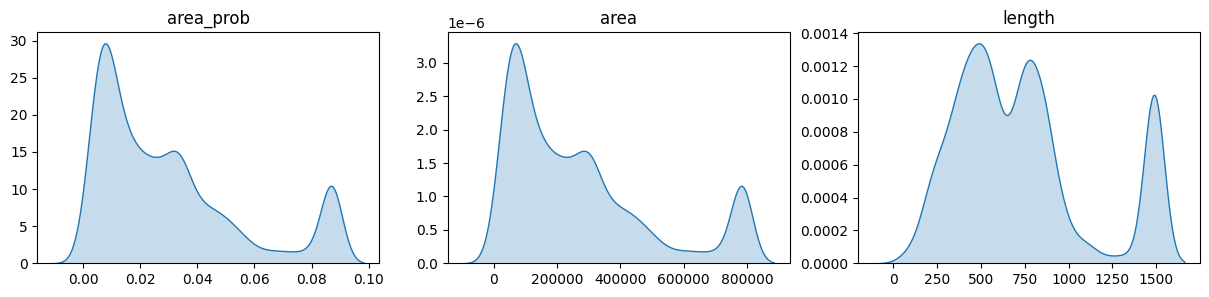

In [20]:
a, b = 1, 3
k = 0
fig, ax = plt.subplots(a, b, figsize = (15, 3))
for i in range(a):
    for j in range(b):
        sns.kdeplot(data = X_train, x = skew_feat[k], shade=True, ax = ax[j])
        ax[j].set(ylabel = None, xlabel = None, title = skew_feat[k])
        k += 1
        if k >= len(skewness):
            break

In [21]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method = 'yeo-johnson')
X_train[skew_feat] = pt.fit_transform(X_train[skew_feat])
X_test[skew_feat] = pt.transform(X_test[skew_feat])

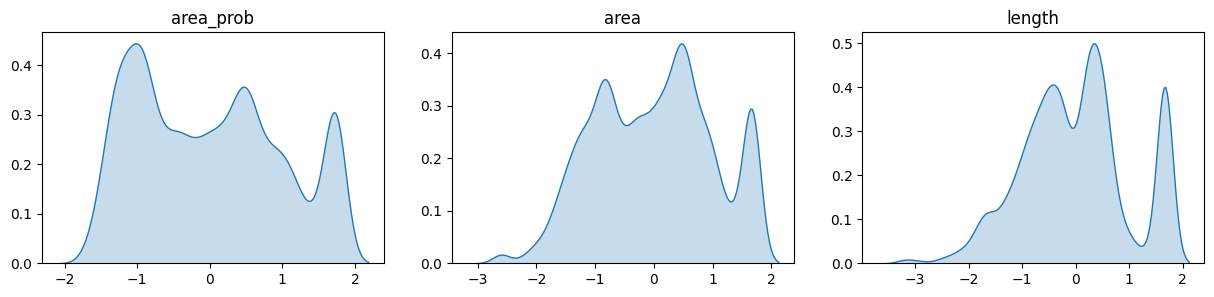

In [22]:
a, b = 1, 3
k = 0
fig, ax = plt.subplots(a, b, figsize = (15, 3))
for i in range(a):
    for j in range(b):
        sns.kdeplot(data = X_train, x = skew_feat[k], shade=True, ax = ax[j])
        ax[j].set(ylabel = None, xlabel = None, title = skew_feat[k])
        k += 1
        if k >= len(skewness):
            break

### Scaler

In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train[features] = scaler.fit_transform(X_train[features])
X_test[features] = scaler.transform(X_test[features])

### Heatmap

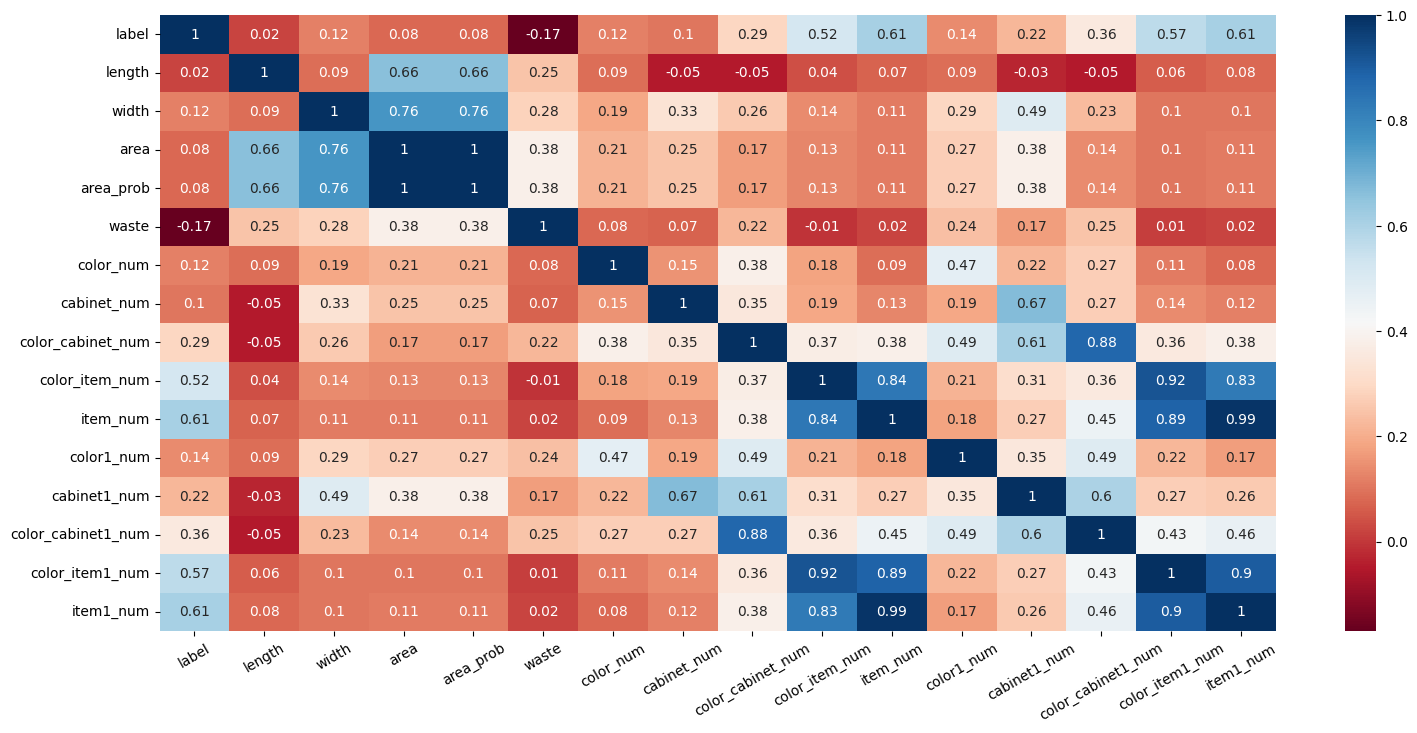

In [24]:
df1 = pd.concat([y_train, X_train], axis = 1)
plt.figure(figsize=(18, 8))
corr = df1.corr("spearman").round(2)
sns.heatmap(data = corr, annot=True, cmap = 'RdBu')
plt.xticks(rotation = 30)
plt.show()

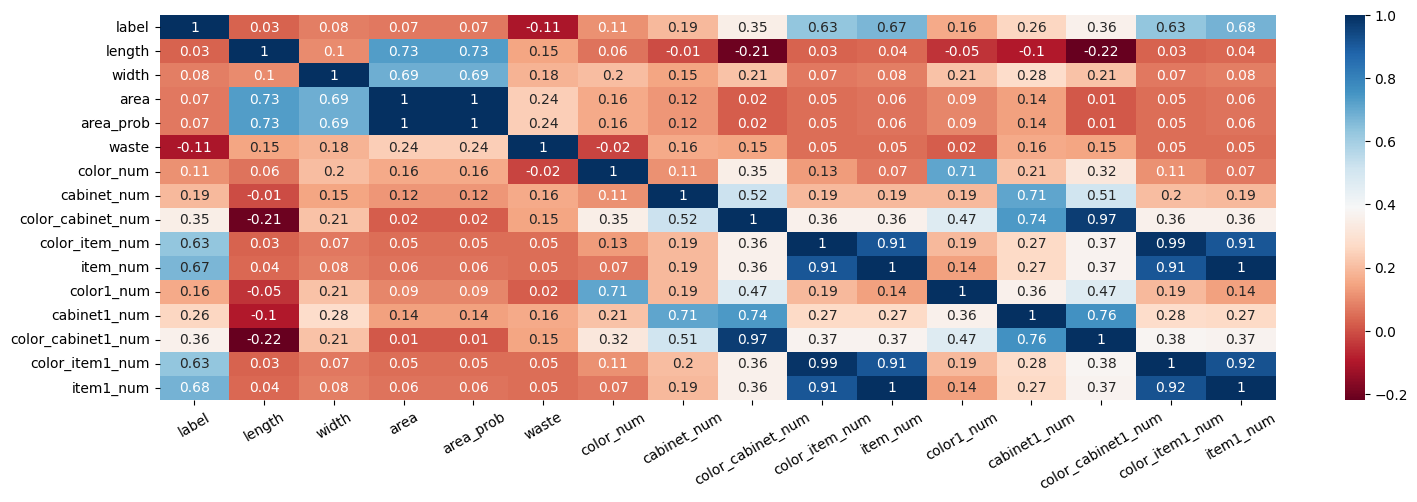

In [25]:
df1 = pd.concat([y_test, X_test], axis = 1)
plt.figure(figsize=(18, 5))
corr = df1.corr("spearman").round(2)
sns.heatmap(data = corr, annot=True, cmap = 'RdBu')
plt.xticks(rotation = 30)
plt.show()

### ML Model

In [26]:
print("The number of target.")
count = pd.DataFrame(
    [
    y_train.value_counts().to_dict(),
    y_test.value_counts().to_dict(),
    ], 
    index = ["train", "test"],
    columns = [0, 1, 2, 3, 4]
    )
count["total"] = count.sum(axis = 1)
count

The number of target.


,0,1,2,3,4,total
train,6215,2261,155,4857,512,14000
test,1186,546,8,554,125,2419


#### adjust hyperparameter

param_grid = {
    'learning_rate': np.arange(0.05, 0.31, 0.05),
    'max_depth': np.arange(3, 11, 1),
    'min_child_weight': np.arange(1, 9, 1),
    'gamma': np.arange(0, 0.5, 0.1),
    'subsample': np.arange(0.5, 1.0, 0.1),
    'colsample_bytree': np.arange(0.6, 1.0, 0.1),
    'n_estimators': np.arange(50, 250, 50)
}

from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

xgb_model = XGBClassifier()

random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_grid,
    n_iter=100,          # Number of parameter settings that are sampled
    scoring='accuracy',  # Scoring metric to optimize
    cv=5,                # Cross-validation folds
    verbose=2,
    n_jobs=-1            # Use all available CPU cores
)
random_search.fit(X_train, y_train)
best_params = random_search.best_params_
best_model = random_search.best_estimator_

accuracy = best_model.score(X_test, y_test)

print("Best Hyperparameters:", best_params)
print("Test Accuracy:", accuracy)

#### train

In [27]:
xgb_args = {'subsample': 0.6, 'n_estimators': 150, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.4, 'colsample_bytree': 0.7}
nn_args = {'activation': 'tanh', 'alpha': 0.0017186516231983927, 'hidden_layer_sizes': (16,), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'solver': 'sgd'}

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
from imblearn.ensemble import EasyEnsembleClassifier, BalancedRandomForestClassifier, BalancedBaggingClassifier, RUSBoostClassifier


models = {
    # "Logistic": LogisticRegression(),
    # "Bayes (Gaussian)": GaussianNB(),
    # "KNN": KNeighborsClassifier(),
    # "SVC": SVC(probability = True),
    "Neural Network": MLPClassifier(**nn_args),
    # "Decision Tree": DecisionTreeClassifier(random_state = random_state),
    # "Random Forest": RandomForestClassifier(random_state = random_state),#, class_weight="balanced"),
    # "Gradient Boost": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(random_state = random_state, **xgb_args),
    # "LightGBM": LGBMClassifier(random_state = random_state),
    # "Bayes (Complement)": ComplementNB(), # for imbalance data (X cannot be negative)
    # "Easy Ensemble (AdaBoost)":EasyEnsembleClassifier(random_state = random_state),
    # "Easy Ensemble (Logistic)":EasyEnsembleClassifier(random_state = random_state, base_estimator = LogisticRegression()),
    # "Easy Ensemble (SVC)":EasyEnsembleClassifier(random_state = random_state, base_estimator = SVC(probability = True)),
}

for name, model in models.items():
    model.fit(X_train, y_train)
    print(name + " trained.")

Neural Network trained.
XGBoost trained.


#### score

In [29]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, precision_score, f1_score, fbeta_score, ConfusionMatrixDisplay
from sklearn.model_selection import ShuffleSplit, cross_val_score
import matplotlib.pyplot as plt

round_ = 2
average = "weighted"
col = [("accuracy", "train"), ("accuracy", "test"), ("precision", "train"), ("precision", "test"), ("recall", "train"), ("recall", "test"), ("f1", "train"), ("f1", "test")]

flag = 1
cv_flag = 1
if cv_flag:
    col.append((("accuracy", "cv")))
col = pd.MultiIndex.from_tuples(col)

pred_trains = pd.DataFrame(y_train)
pred_tests = pd.DataFrame(y_test)
scores = pd.DataFrame()

for name, model in models.items():
    pred_train = model.predict(X_train)
    pred_test  = model.predict(X_test)
    pred_trains[f"{name}_train"] = pred_train
    pred_tests[f"{name}_test"] = pred_test

    acc_train  = accuracy_score(y_train, pred_train).round(round_)
    acc_test   = accuracy_score(y_test, pred_test).round(round_)

    precision_train  = precision_score(y_train, pred_train, average = average).round(round_)
    precision_test   = precision_score(y_test, pred_test, average = average).round(round_)

    recall_train  = recall_score(y_train, pred_train, average = average).round(round_)
    recall_test   = recall_score(y_test, pred_test, average = average).round(round_)

    f1_train = f1_score(y_train, pred_train, average = average).round(round_)
    f1_test = f1_score(y_test, pred_test, average = average).round(round_)

    score = [acc_train, acc_test, precision_train, precision_test, recall_train, recall_test, f1_train, f1_test]

    if cv_flag:
        cv_scores = cross_val_score(model, X_train, y_train, cv = 3, scoring = 'accuracy')
        cv_score = cv_scores.mean().round(round_)
        score.append(cv_score)
    
    scores.loc[name, col] = score

#scores = scores.loc[["Neural Network"]]
scores = scores.sort_values(("f1", "test"), ascending = False)#.iloc[:3]
scores

accuracy       precision       recall          f1        \
                  train  test     train  test  train  test train  test   
XGBoost            0.87  0.86      0.87  0.86   0.87  0.86  0.87  0.86   
Neural Network     0.82  0.84      0.82  0.85   0.82  0.84  0.82  0.84   

               accuracy  
                     cv  
XGBoost            0.82  
Neural Network     0.80

#### chart

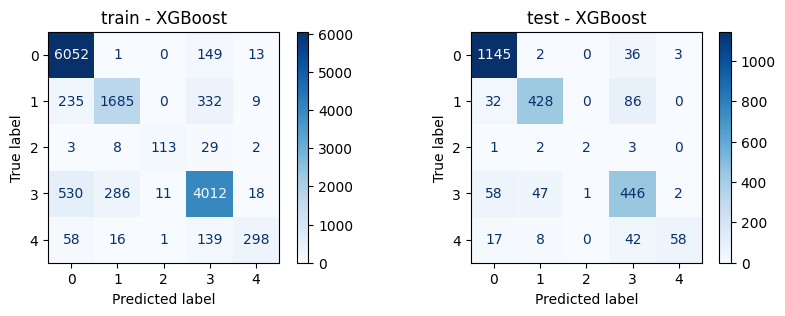

Classification Report of Test:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      1186
           1       0.88      0.78      0.83       546
           2       0.67      0.25      0.36         8
           3       0.73      0.81      0.76       554
           4       0.92      0.46      0.62       125

    accuracy                           0.86      2419
   macro avg       0.82      0.65      0.70      2419
weighted avg       0.86      0.86      0.86      2419

----------------------------------------------------------------------------------------------------


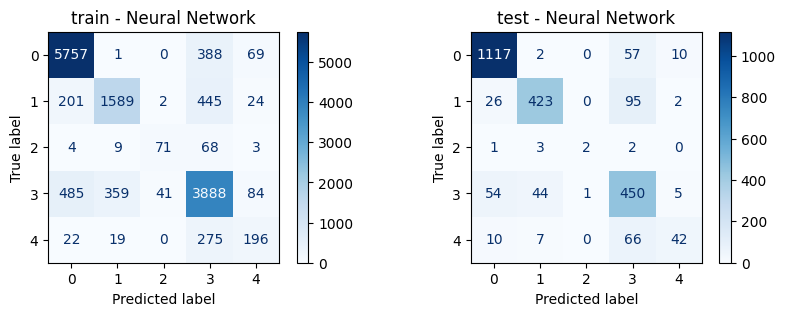

Classification Report of Test:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      1186
           1       0.88      0.77      0.83       546
           2       0.67      0.25      0.36         8
           3       0.67      0.81      0.74       554
           4       0.71      0.34      0.46       125

    accuracy                           0.84      2419
   macro avg       0.77      0.62      0.66      2419
weighted avg       0.85      0.84      0.84      2419

----------------------------------------------------------------------------------------------------


In [30]:
for name in scores.index:
    fig, ax = plt.subplots(1, 2, figsize = (10, 3))
    disp = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, pred_trains[f"{name}_train"]), display_labels = (set(pred_train) | set(y_train)))
    disp.plot(cmap = plt.cm.Blues, ax = ax[0])
    ax[0].set_title(f"train - {name}")

    disp = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, pred_tests[f"{name}_test"]), display_labels = (set(pred_test) | set(y_test)))
    disp.plot(cmap = plt.cm.Blues, ax = ax[1])
    ax[1].set_title(f"test - {name}")
    plt.show()

    print(f"Classification Report of Test:\n{classification_report(y_test, pred_tests[f'{name}_test'])}")
    print("-"*100)

In [31]:
model = models["XGBoost"]

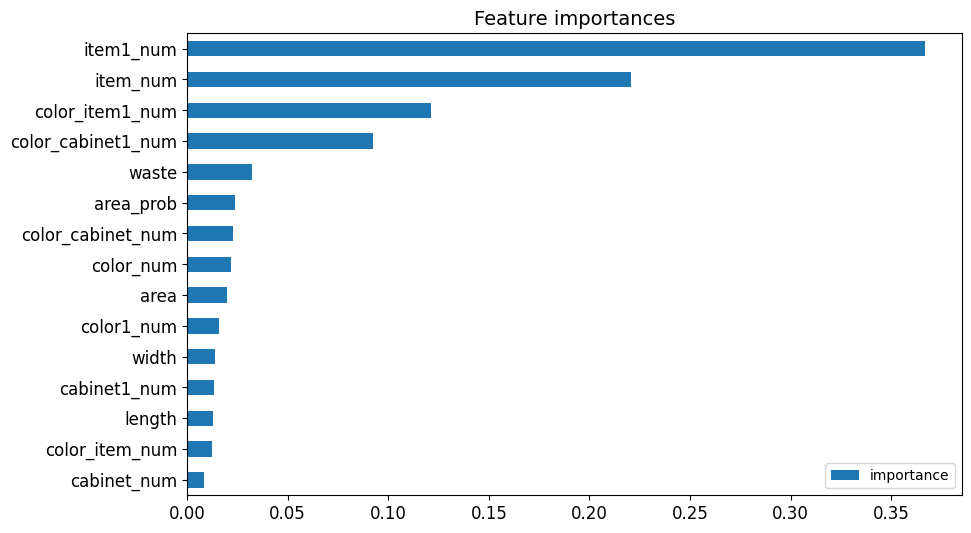

In [32]:
fig, ax = plt.subplots(figsize = (10, 6))
imp = pd.DataFrame(model.feature_importances_, index = X_train.columns, columns = ["importance"])
imp = imp.query("importance != 0").sort_values("importance")
imp.plot(kind = "barh", ax = ax, fontsize = 12)
ax.set_title("Feature importances", fontsize = 14)
fig.show()
fig.savefig(f"{model_path}/feature_importance.png")

#### save model

In [33]:
pickle.dump(features, open(os.path.join(model_detail, "feat_order.pkl"), "wb"))
pickle.dump(outlier_boundary, open(os.path.join(model_detail, "outlier_boundary.pkl"), "wb"))
pickle.dump(skew_feat, open(os.path.join(model_detail, "skew_feat.pkl"), "wb"))
pickle.dump(pt, open(os.path.join(model_detail, "power_tf.pkl"), "wb"))
pickle.dump(scaler, open(os.path.join(model_detail, "scaler.pkl"), "wb"))
pickle.dump(model, open(os.path.join(model_detail, "model.pkl"), "wb"))

### Shap

In [34]:
model = models["XGBoost"]

In [35]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

print(shap_values[0].shape, shap_values[1].shape, shap_values[2].shape)

(14000, 15) (14000, 15) (14000, 15)


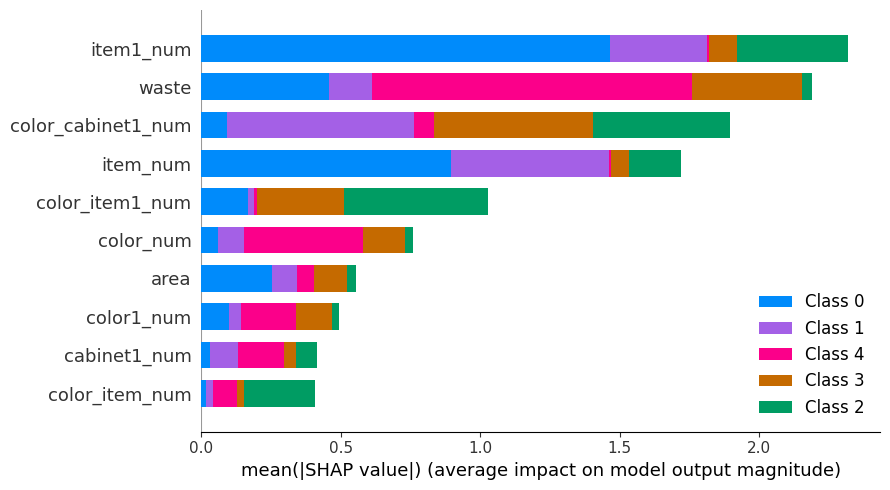

In [36]:
shap.summary_plot(shap_values, X_train, plot_size=(9, 5), max_display = 10, show=True)

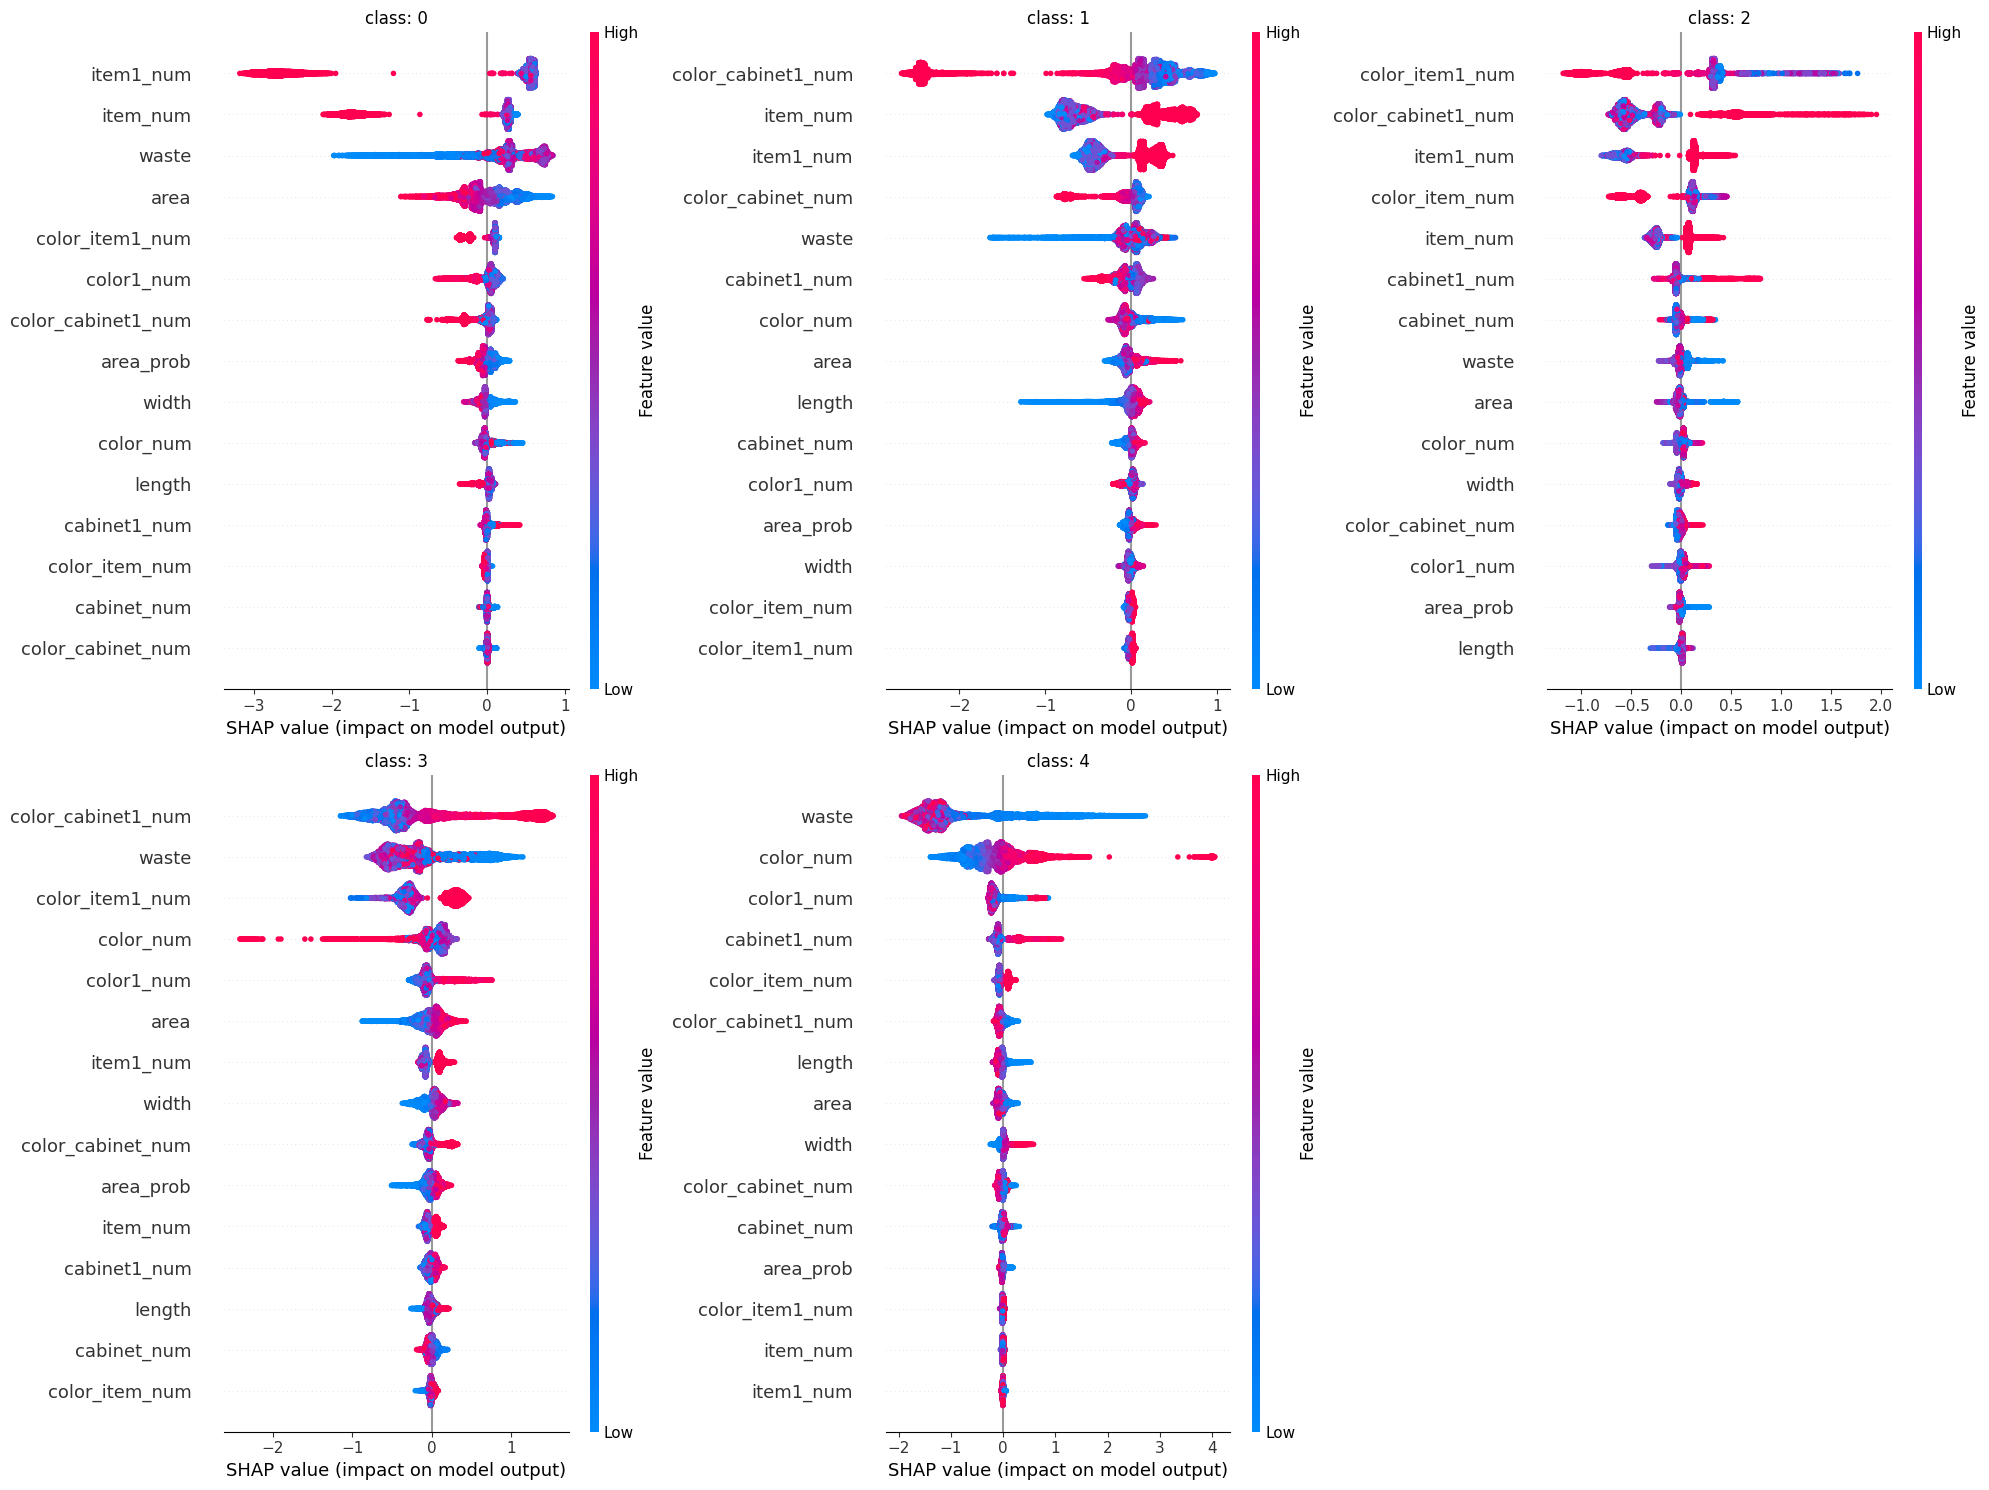

In [37]:
plt.figure(figsize=(20,15))
for label in range(5):
    plt.subplot(2, 3, label+1)
    shap.summary_plot(shap_values[label], X_train, plot_size=None, show=False)
    plt.title(f"class: {label}")

#0: 因color或空間不足而換新plate，找長寬最大的item
#1: 同plate，同cabinet，同item
#2: 同plate，同cabinet，不同item
#3: 同plate，不同cabinet，同item
#4: 同plate，不同cabinet，不同item